In [1]:
# Install torchaudio
!pip install torchaudio==0.9.1 -q
import librosa
import torchaudio
from torchaudio import transforms

     |████████████████████████████████| 1.9 MB 13.4 MB/s 
     |████████████████████████████████| 831.4 MB 6.7 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.


In [2]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
IMG_PATH = '/content/drive/MyDrive/melSpectrogram'
AUD_PATH = '/content/drive/MyDrive/Annamayya'

## Basic Data cleanup operations

In [5]:
# Consider ragas that have at least 10 samples.
RAGAM_MIN_COUNT = 10

In [6]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
adata = pd.read_json('/content/drive/MyDrive/mp3_data_genres.json')

In [7]:
data['exists'] = data.apply(lambda x:os.path.exists(os.path.join(AUD_PATH,x['MP3 File'])),axis=1)
data = data[data.exists]

In [8]:
def get_offset(adata, id):
  l = adata[adata.Samputi==id]['Offset'].tolist()
  return 0 if len(l) == 0 else l[0]
data['Offset'] = data.apply(lambda x:get_offset(adata, x.Samputi), axis=1)

In [9]:
all_samples = data.Ragam.value_counts().index
low_samples = all_samples[data.Ragam.value_counts()<RAGAM_MIN_COUNT]
# Drop these rows.
for s in low_samples:
  data = data[data.Ragam!=s]

In [10]:
le = LabelEncoder()
le.fit_transform(data['Ragam'])
data['RagamCode'] = data.apply(lambda x:le.transform([x.Ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

In [11]:
data['Ragam'].value_counts()

లలిత            98
సాళంగనాట        94
సామంతం          89
బౌళి            70
శంకరాభరణం       68
శ్రీరాగం        65
రామక్రియ        61
ముఖారి          55
పాడి            50
ఆహిరి           45
దేసాళం          40
దేవగాంధారి      35
శుద్ధవసంతం      33
భూపాలం          32
దేసాక్షి        29
గుండుక్రియ      28
భైరవి           27
నాట             25
వరాళి           22
మలహరి           20
ధన్నాసి         20
కాంబోది         19
మాళవి           18
మాళవిగౌళ        18
గుజ్జరి         15
కన్నడగౌళ        15
గౌళ             14
బౌళిరామక్రియ    13
నాదరామక్రియ     11
సాళంగం          11
Name: Ragam, dtype: int64

In [12]:
print(f'Unique Ragas : {n_labels}')

Unique Ragas : 30


In [13]:
for c in le.classes_:
  print(f'{c} : {le.transform([c])}')

ఆహిరి : [0]
కన్నడగౌళ : [1]
కాంబోది : [2]
గుండుక్రియ : [3]
గుజ్జరి : [4]
గౌళ : [5]
దేవగాంధారి : [6]
దేసాక్షి : [7]
దేసాళం : [8]
ధన్నాసి : [9]
నాట : [10]
నాదరామక్రియ : [11]
పాడి : [12]
బౌళి : [13]
బౌళిరామక్రియ : [14]
భూపాలం : [15]
భైరవి : [16]
మలహరి : [17]
మాళవి : [18]
మాళవిగౌళ : [19]
ముఖారి : [20]
రామక్రియ : [21]
లలిత : [22]
వరాళి : [23]
శంకరాభరణం : [24]
శుద్ధవసంతం : [25]
శ్రీరాగం : [26]
సామంతం : [27]
సాళంగం : [28]
సాళంగనాట : [29]


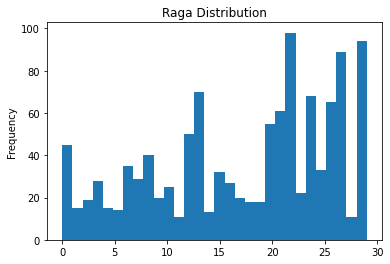

In [14]:
data['RagamCode'].plot.hist(bins=n_labels)
plt.title('Raga Distribution')
plt.show()

In [15]:
data['Offset'].fillna(60,inplace=True)

## Common functions that are needed for rest of notebook

In [16]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [17]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight('balanced',
                                         np.unique(labels),
                                         labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [18]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [19]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions):
    s = 'micro'
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [20]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, hidden: model(data, hidden) if hidden else model(data)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      print('Training Model')
      model.train()
  else:
      print('Evaluating Model')
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at:
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [21]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [22]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [23]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data['RagamCode']
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[['mfcc_mean']], data['RagamCode'])):
    print(f'FOLD {fold} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout,**mdlargs)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data['RagamCode'].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        print('Epoch {:} / {:}'.format(epoch + 1, epochs))
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        print(f'Losses - Train : {train_loss:.3f} / Validation : {valid_loss:.3f}')
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Time for epoch : {(e_end - e_start).total_seconds()} seconds')
    print('On Train Data')
    print(classification_report(best_scores['train_labels'], best_scores['train_predictions']))
    print('On Test Data')
    print(classification_report(best_scores['test_labels'], best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Time for fold {fold} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(train_predictions,train_labels))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(test_predictions,test_labels))
  if plot:
    plot_results(results, title)
  return results

In [24]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by='validation_f1', ascending=False, inplace=True)
    return p

# Experiment 1 - Using Mean levels of MFCC Values
40 MFCC levels are precomputed using MATLAB
## Experiment 1.1 - Feed forward model

In [25]:
class MfccDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.mfcc_vals[index][1:], self.labels[index]

    def __getitem__(self, index):
        return self.mfcc_vals[index][1:], self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = torch.tensor([[_ for _ in data['mfcc_mean'].iloc[x]] for x in train_ids])
      test_vals = torch.tensor([[_ for _ in data['mfcc_mean'].iloc[x]] for x in test_ids])
      train_data = MfccDataset(train_lbls, train_vals)
      test_data = MfccDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [26]:
class MfccFtVecRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.n_labels = n_labels
        self.mfcc = nn.Sequential(
            nn.Linear(40, 80), nn.GELU(),
            nn.Linear(80, 160), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(160, 320), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(320, self.n_labels)
        )
        
    def forward(self,x):
        return self.mfcc(x)

FOLD 0 
 Data Sizes (Train/Test) : 912/228
Class Weights : [0.84444444 2.53333333 2.         1.35714286 2.53333333 2.71428571
 1.08571429 1.31034483 0.95       1.9        1.52       3.45454545
 0.76       0.54285714 2.92307692 1.1875     1.40740741 1.9
 2.11111111 2.11111111 0.69090909 0.62295082 0.3877551  1.72727273
 0.55882353 1.15151515 0.58461538 0.42696629 3.45454545 0.40425532]
Epoch 1 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.459 / Validation : 3.438
Time for epoch : 0.082107 seconds
Epoch 2 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.435 / Validation : 3.429
Time for epoch : 0.081976 seconds
Epoch 3 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.402 / Validation : 3.441
Time for epoch : 0.077161 seconds
Epoch 4 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.376 / Validation : 3.460
Time for epoch : 0.071773 seconds
Epoch 5 / 10

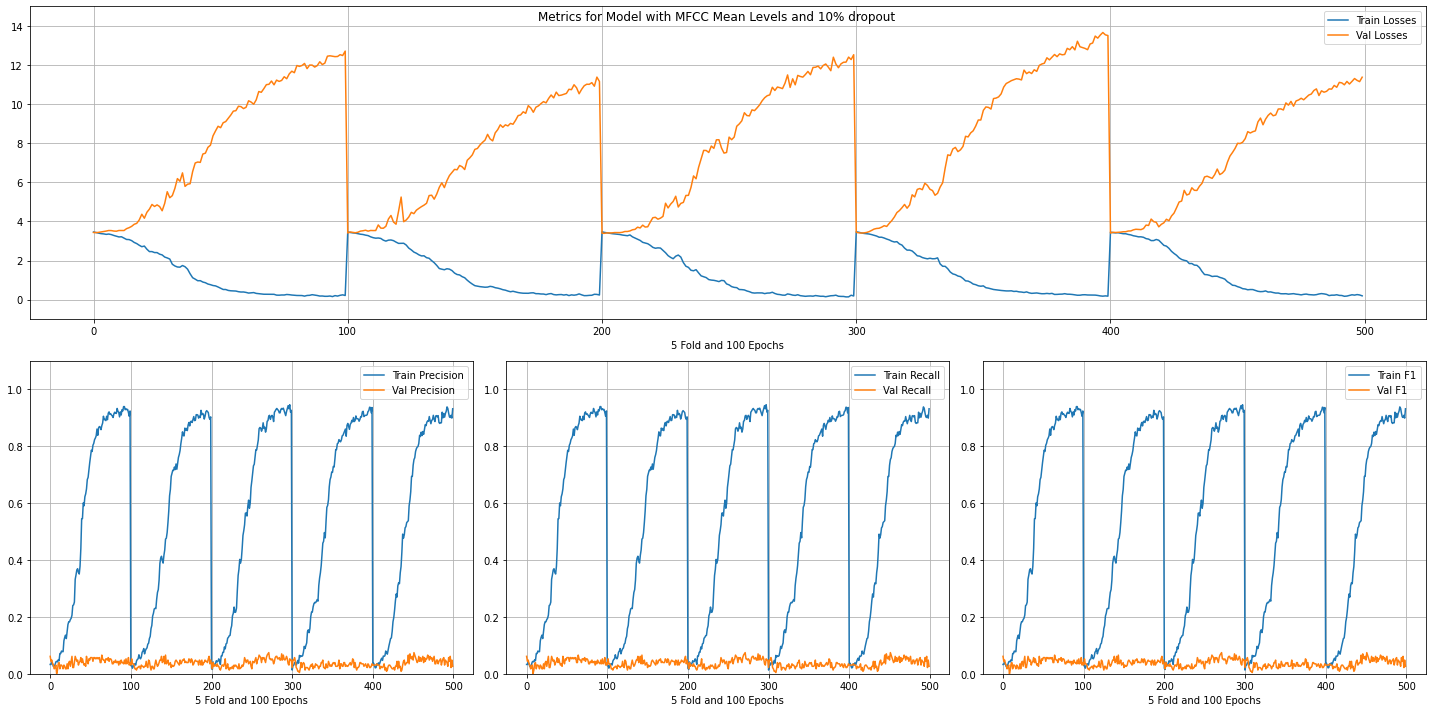

In [27]:
mfcc_single_results = train_model(data, MfccDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : 'Model with MFCC Mean Levels and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 100,
                                   'model' : MfccFtVecRaga})

In [28]:
print('*** Results for Model with MFCC Mean Levels and 10% dropout ***')
mfcc_single_results_df = results_to_df(mfcc_single_results)
mfcc_single_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with MFCC Mean Levels and 10% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
71,0.906798,0.074561,0.906798,0.074561,0.906798,0.074561,0.231912,10.795414
51,0.753289,0.074561,0.753289,0.074561,0.753289,0.074561,0.624013,7.985835
87,0.933114,0.070175,0.933114,0.070175,0.933114,0.070175,0.174009,11.979033
70,0.890351,0.070175,0.890351,0.070175,0.890351,0.070175,0.259516,10.840767
46,0.610746,0.070175,0.610746,0.070175,0.610746,0.070175,0.916071,7.028059
...,...,...,...,...,...,...,...,...
17,0.073465,0.008772,0.073465,0.008772,0.073465,0.008772,3.022389,3.988844
7,0.047149,0.008772,0.047149,0.008772,0.047149,0.008772,3.292081,3.608381
8,0.037281,0.008772,0.037281,0.008772,0.037281,0.008772,3.254094,3.641316
9,0.064693,0.004386,0.064693,0.004386,0.064693,0.004386,3.193338,3.652713


FOLD 0 
 Data Sizes (Train/Test) : 912/228
Class Weights : [0.84444444 2.53333333 2.         1.35714286 2.53333333 2.71428571
 1.08571429 1.31034483 0.95       1.9        1.52       3.45454545
 0.76       0.54285714 2.92307692 1.1875     1.40740741 1.9
 2.11111111 2.11111111 0.69090909 0.62295082 0.3877551  1.72727273
 0.55882353 1.15151515 0.58461538 0.42696629 3.45454545 0.40425532]
Epoch 1 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.475 / Validation : 3.447
Time for epoch : 0.097455 seconds
Epoch 2 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.443 / Validation : 3.422
Time for epoch : 0.089238 seconds
Epoch 3 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.400 / Validation : 3.451
Time for epoch : 0.08433 seconds
Epoch 4 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.377 / Validation : 3.482
Time for epoch : 0.076254 seconds
Epoch 5 / 100

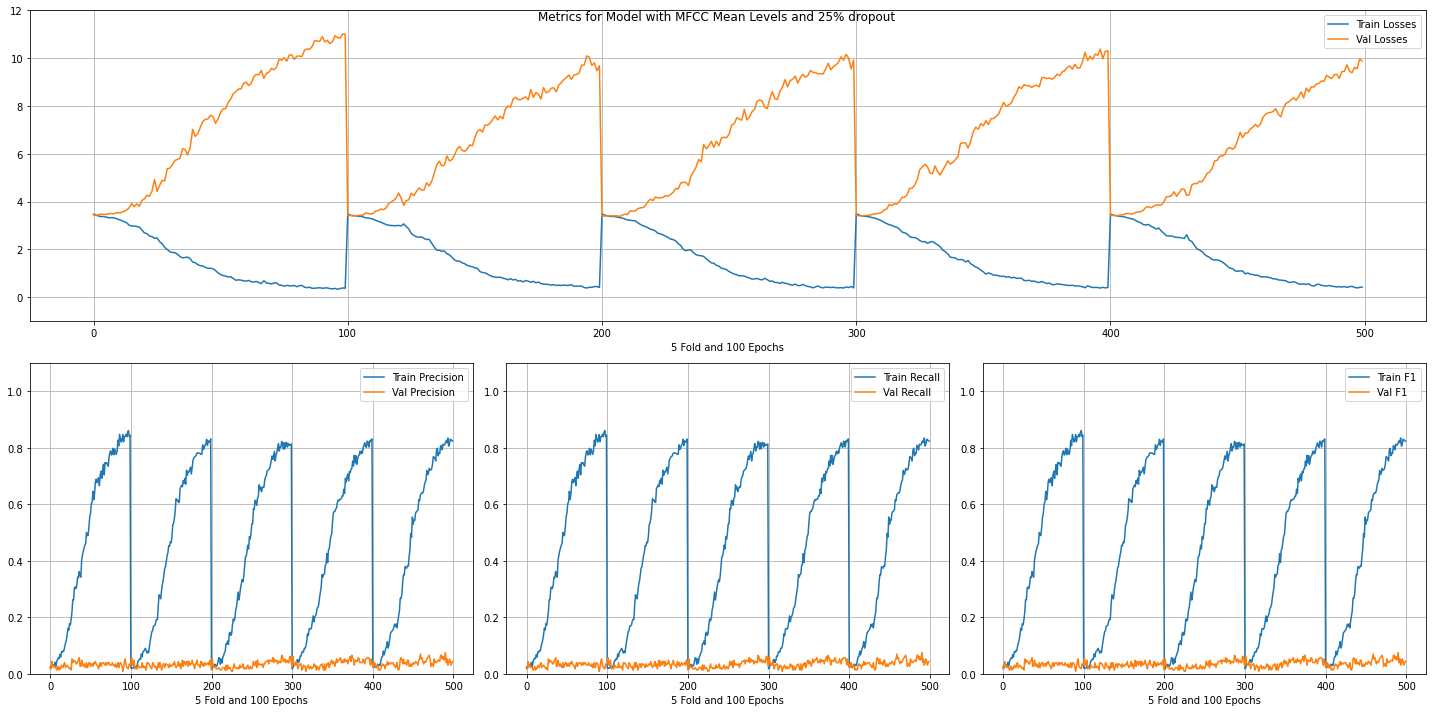

In [29]:
mfcc_single_results = train_model(data, MfccDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.25,
                                   'title' : 'Model with MFCC Mean Levels and 25% dropout',
                                   'plot' : True,
                                   'epochs' : 100,
                                   'model' : MfccFtVecRaga})

In [30]:
print('*** Results for Model with MFCC Mean Levels and 25% dropout ***')
mfcc_single_results_df = results_to_df(mfcc_single_results)
mfcc_single_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with MFCC Mean Levels and 25% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
90,0.819079,0.074561,0.819079,0.074561,0.819079,0.074561,0.444628,9.155795
59,0.633772,0.070175,0.633772,0.070175,0.633772,0.070175,0.862117,7.250276
87,0.822368,0.065789,0.822368,0.065789,0.822368,0.065789,0.393405,9.345691
84,0.808114,0.065789,0.808114,0.065789,0.808114,0.065789,0.479911,9.034718
85,0.804825,0.065789,0.804825,0.065789,0.804825,0.065789,0.470329,9.284159
...,...,...,...,...,...,...,...,...
0,0.017544,0.013158,0.017544,0.013158,0.017544,0.013158,3.495209,3.394989
90,0.846491,0.008772,0.846491,0.008772,0.846491,0.008772,0.377341,10.902164
26,0.174342,0.008772,0.174342,0.008772,0.174342,0.008772,2.499277,4.229466
25,0.142544,0.008772,0.142544,0.008772,0.142544,0.008772,2.558402,4.252316


FOLD 0 
 Data Sizes (Train/Test) : 912/228
Class Weights : [0.84444444 2.53333333 2.         1.35714286 2.53333333 2.71428571
 1.08571429 1.31034483 0.95       1.9        1.52       3.45454545
 0.76       0.54285714 2.92307692 1.1875     1.40740741 1.9
 2.11111111 2.11111111 0.69090909 0.62295082 0.3877551  1.72727273
 0.55882353 1.15151515 0.58461538 0.42696629 3.45454545 0.40425532]
Epoch 1 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.484 / Validation : 3.475
Time for epoch : 0.080019 seconds
Epoch 2 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.447 / Validation : 3.430
Time for epoch : 0.087569 seconds
Epoch 3 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.414 / Validation : 3.428
Time for epoch : 0.078201 seconds
Epoch 4 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.386 / Validation : 3.451
Time for epoch : 0.073601 seconds
Epoch 5 / 10

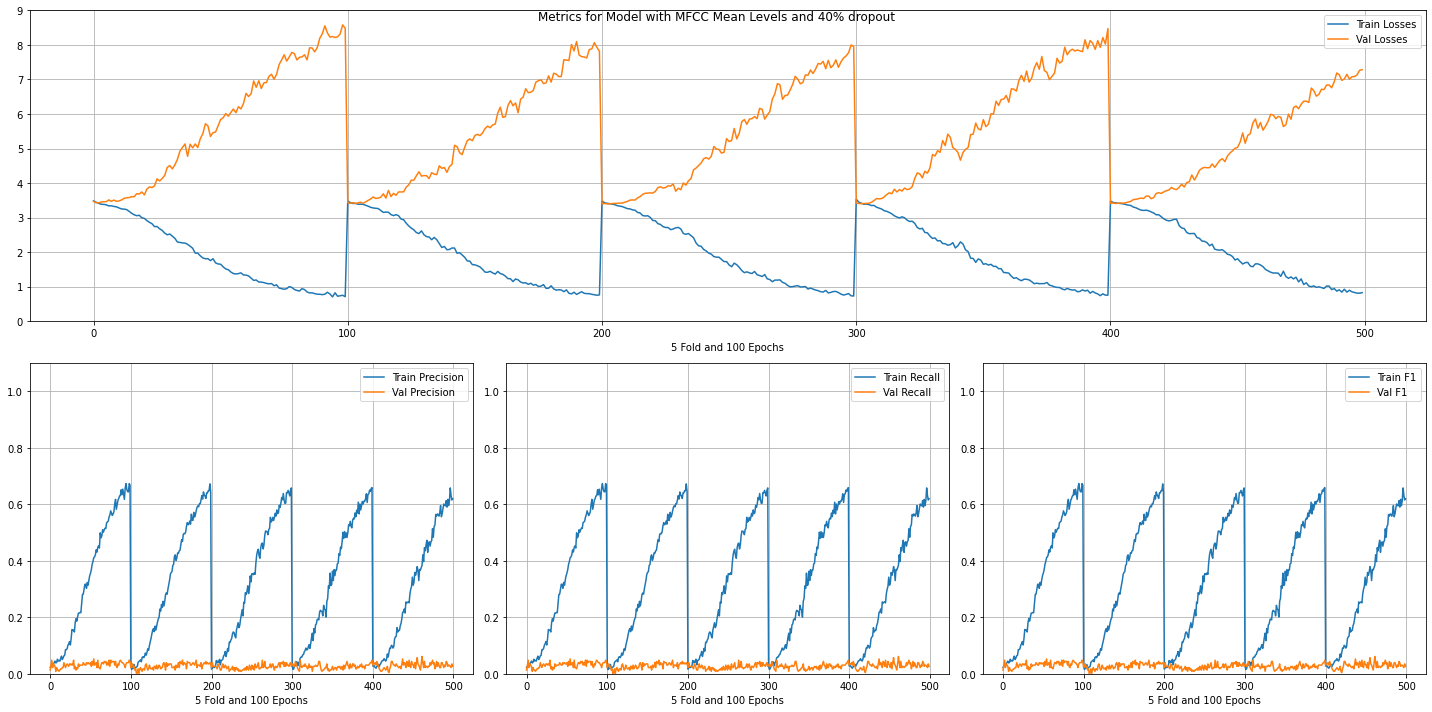

In [31]:
mfcc_single_results = train_model(data, MfccDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.4,
                                   'title' : 'Model with MFCC Mean Levels and 40% dropout',
                                   'plot' : True,
                                   'epochs' : 100,
                                   'model' : MfccFtVecRaga})

In [32]:
print('*** Results for Model with MFCC Mean Levels and 40% dropout ***')
mfcc_single_results_df = results_to_df(mfcc_single_results)
mfcc_single_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with MFCC Mean Levels and 40% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
61,0.383772,0.061404,0.383772,0.061404,0.383772,0.061404,1.496473,5.648891
55,0.379386,0.057018,0.379386,0.057018,0.379386,0.057018,1.597384,5.433051
54,0.411184,0.052632,0.411184,0.052632,0.411184,0.052632,1.424778,6.041753
37,0.218202,0.052632,0.218202,0.052632,0.218202,0.052632,2.312011,4.454323
98,0.673246,0.048246,0.673246,0.048246,0.673246,0.048246,0.750355,8.580371
...,...,...,...,...,...,...,...,...
10,0.037281,0.008772,0.037281,0.008772,0.037281,0.008772,3.284863,3.530389
20,0.075658,0.004386,0.075658,0.004386,0.075658,0.004386,3.023384,3.699298
8,0.026316,0.004386,0.026316,0.004386,0.026316,0.004386,3.330786,3.495892
10,0.043860,0.000000,0.043860,0.000000,0.043860,0.000000,3.279251,3.597878


## Experiment 1.2 - ML Models

In [33]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from functools import reduce

In [34]:
def do_grid_search(_X,_y,mdl,params,scoring,key,n=5):
    pipe = Pipeline([('scaler', MinMaxScaler()), ('mdl', mdl)])
    nparams = {f'mdl__{k}':params[k] for k in params}
    est = GridSearchCV(pipe,nparams,scoring=scoring,cv=n,return_train_score=True,refit=key,n_jobs=-1)
    est.fit(_X,_y)
    return est

In [35]:
def plot_grid_results(est,keys,title):
    plt.figure(figsize=[12,3])
    for i,k in enumerate(keys):
        train_score = reduce(lambda a,b: list(a) + list(b), [est.cv_results_[f'split{x}_train_{k}'] for x in range(est.cv)])
        test_score = reduce(lambda a,b: list(a) + list(b), [est.cv_results_[f'split{x}_test_{k}'] for x in range(est.cv)])
        plt.subplot(1,len(keys),i+1)
        plt.plot(train_score)
        plt.plot(test_score)
        plt.legend(['Train','Test'])
        plt.ylim([0,1.1])
        plt.grid()
        plt.title(k)
    plt.suptitle(title, y=1.0)
    plt.tight_layout(h_pad=1)
    plt.show()

In [36]:
scorers = {
    'Precision' : make_scorer(precision_score,average='micro'),
    'Recall' : make_scorer(recall_score,average='micro'),
    'F1_Score' : make_scorer(f1_score,average='micro'),
          }

In [37]:
RAND_STATE = 42
Models = {
    'Multi Nomial Naive Bayes Classification': (MultinomialNB(),{'alpha':[1e-3,1e-4,1e-5]}),
    'Bernoulli Naive Bayes Classification': (BernoulliNB(),{'alpha':[1e-1,1e-3,1e-4,1e-5]}),
    'Complement Naive Bayes Classification': (ComplementNB(),{'alpha':[1e-1,1e-3,1e-4,1e-5]}),
    'Logistic Regression' : (LogisticRegression(random_state=RAND_STATE),{'tol':[1e-1,1e-3,1e-4,1e-5]}),
    'Nearest Centroid Classification': (NearestCentroid(),{}),
    'Ridge Classifier': (RidgeClassifier(random_state=RAND_STATE), {'alpha':[1e-1,1e-3,1e-4,1e-5]}),
    'SGD Classifier': (SGDClassifier(random_state=RAND_STATE),{'alpha':[1e-1,1e-3,1e-4,1e-5]}),
    'Linear SVC': (LinearSVC(random_state=RAND_STATE),{'tol':[1e-2,1e-4,1e-1]}),
    'Random Forest Classifier': (RandomForestClassifier(random_state=RAND_STATE),{'min_samples_leaf':[2,5,10]}),
    'XGB Classifier': (XGBClassifier(use_label_encoder=True),{'eta':[0.1,0.3,0.5],'objective':['binary:logistic']}),
}

In [38]:
def run_kfold(n, Models, X, y):
    Res = {}
    for k in Models:
        print(f'Model {k}')
        Res[k] = do_grid_search(X,y,Models[k][0],Models[k][1],scorers,'F1_Score',n)
        print('Mean F1 Score : ' ,100*Res[k].best_score_, '%')
        plot_grid_results(Res[k],list(scorers.keys()),f'{n} Fold {k}')
    return Res

In [39]:
X = pd.DataFrame()
for i in range(1,41):
  # MATLAB Produces 41 element MFCC vectors of which 1st element shall be ignored.
  X[i] = data.apply(lambda x:x['mfcc_mean'][i], axis=1)
y = data.apply(lambda x:x['RagamCode'], axis=1)

Model Multi Nomial Naive Bayes Classification
Mean F1 Score :  9.12280701754386 %


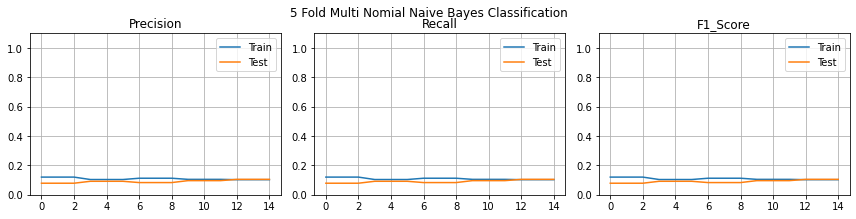

Model Bernoulli Naive Bayes Classification
Mean F1 Score :  8.421052631578947 %


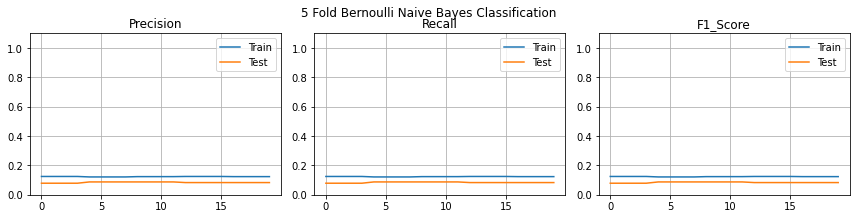

Model Complement Naive Bayes Classification
Mean F1 Score :  5.7894736842105265 %


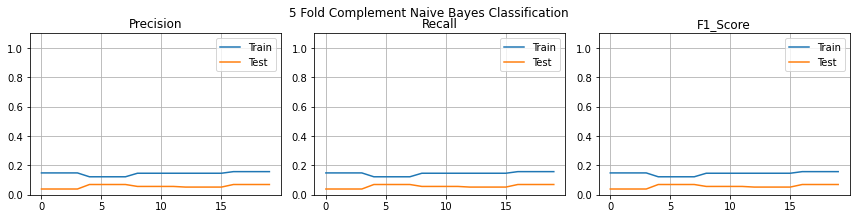

Model Logistic Regression
Mean F1 Score :  7.368421052631578 %


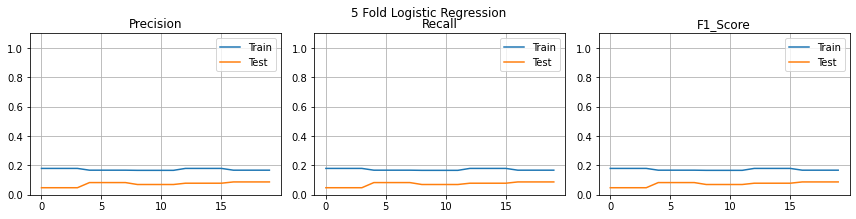

Model Nearest Centroid Classification
Mean F1 Score :  2.631578947368421 %


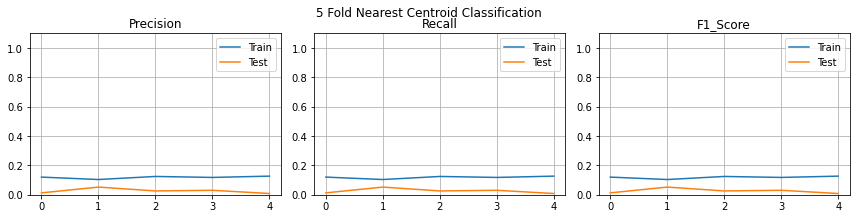

Model Ridge Classifier
Mean F1 Score :  7.456140350877193 %


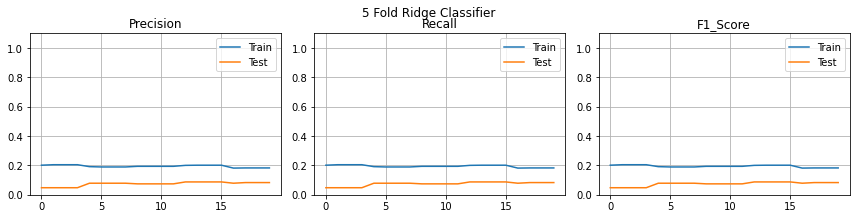

Model SGD Classifier
Mean F1 Score :  4.824561403508771 %


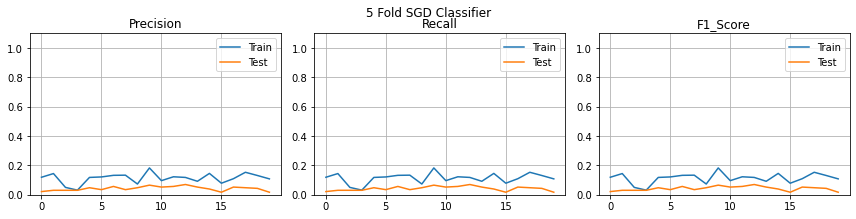

Model Linear SVC
Mean F1 Score :  6.666666666666667 %


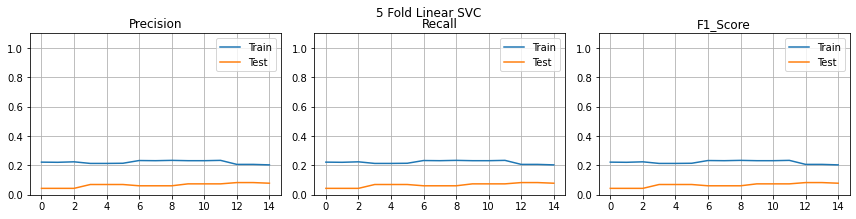

Model Random Forest Classifier
Mean F1 Score :  8.333333333333332 %


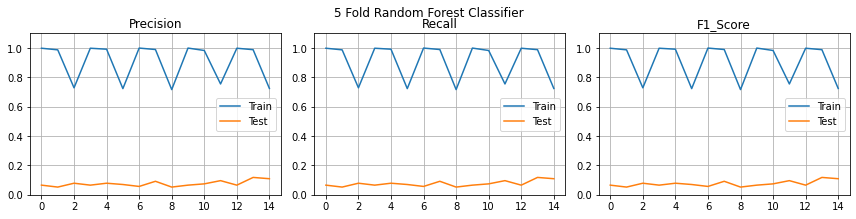

Model XGB Classifier
Mean F1 Score :  6.491228070175439 %


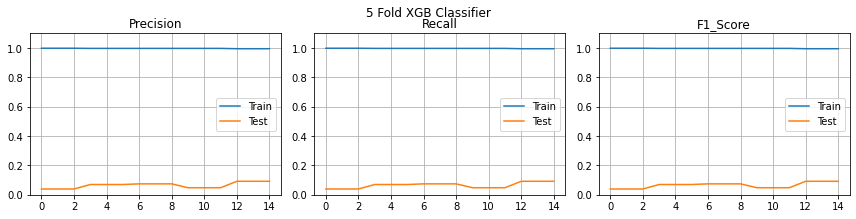

In [40]:
Results = {}
Results['5Fold'] = run_kfold(5, Models, X, y)

In [41]:
def convert_grid_search_to_df(nfold_result, name):
    res = {'Model':[],
           f'{name} Train F1 Score':[],
           f'{name} Test F1 Score':[],
           f'{name} Train Precision':[],
           f'{name} Test Precision':[],
           f'{name} Train Recall':[],
           f'{name} Test Recall':[],
           'Best Parameters':[]}
    for k in Models:
        res['Model'].append(k)
        iii = nfold_result[k].best_index_
        res[f'{name} Train F1 Score'].append(nfold_result[k].cv_results_['mean_train_F1_Score'][iii])
        res[f'{name} Test F1 Score'].append(nfold_result[k].cv_results_['mean_test_F1_Score'][iii])
        res[f'{name} Train Precision'].append(nfold_result[k].cv_results_['mean_train_Precision'][iii])
        res[f'{name} Test Precision'].append(nfold_result[k].cv_results_['mean_test_Precision'][iii])
        res[f'{name} Train Recall'].append(nfold_result[k].cv_results_['mean_train_Recall'][iii])
        res[f'{name} Test Recall'].append(nfold_result[k].cv_results_['mean_test_Recall'][iii])
        res['Best Parameters'].append(nfold_result[k].best_params_)
    df = pd.DataFrame(data=res)
    df.sort_values(by=f'{name} Test F1 Score', ascending=False, inplace=True)
    return df

In [42]:
fold_5 = convert_grid_search_to_df(Results['5Fold'], '5 Fold')
fold_5

,Model,5 Fold Train F1 Score,5 Fold Test F1 Score,5 Fold Train Precision,5 Fold Test Precision,5 Fold Train Recall,5 Fold Test Recall,Best Parameters
0,Multi Nomial Naive Bayes Classification,0.109211,0.091228,0.109211,0.091228,0.109211,0.091228,{'mdl__alpha': 0.001}
1,Bernoulli Naive Bayes Classification,0.123904,0.084211,0.123904,0.084211,0.123904,0.084211,{'mdl__alpha': 0.1}
8,Random Forest Classifier,0.988596,0.083333,0.988596,0.083333,0.988596,0.083333,{'mdl__min_samples_leaf': 5}
5,Ridge Classifier,0.194737,0.074561,0.194737,0.074561,0.194737,0.074561,{'mdl__alpha': 0.001}
3,Logistic Regression,0.172368,0.073684,0.172368,0.073684,0.172368,0.073684,{'mdl__tol': 0.1}
7,Linear SVC,0.221930,0.066667,0.221930,0.066667,0.221930,0.066667,{'mdl__tol': 0.01}
9,XGB Classifier,0.997588,0.064912,0.997588,0.064912,0.997588,0.064912,"{'mdl__eta': 0.1, 'mdl__objective': 'binary:lo..."
2,Complement Naive Bayes Classification,0.144737,0.057895,0.144737,0.057895,0.144737,0.057895,{'mdl__alpha': 0.1}
6,SGD Classifier,0.107895,0.048246,0.107895,0.048246,0.107895,0.048246,{'mdl__alpha': 0.1}
4,Nearest Centroid Classification,0.119079,0.026316,0.119079,0.026316,0.119079,0.026316,{}


# Experiment 2 - Using 40 MFCC Values for 120 sec duration of each song
## Experiment 2.1 - Using Feed forward model

In [43]:
FREQ = 16000
DURATION = 120
mfcc_tx = transforms.MFCC(FREQ, n_mfcc=40)
def get_mfcc(x, aud_path, mfcc_tx):
  aud_path = os.path.join(aud_path, x['MP3 File'])
  i = torchaudio.info(aud_path)
  waveform, sample_rate = torchaudio.load(aud_path, 
                                          frame_offset=int(x['Offset']*i.sample_rate), 
                                          num_frames= DURATION*i.sample_rate)
  waveform = librosa.to_mono(waveform)
  resampler = transforms.Resample(sample_rate, FREQ)
  if len(waveform) > 0 :
    waveform = resampler(torch.tensor(waveform))
    mfcc = mfcc_tx(waveform)
  else:
    mfcc = []
  return mfcc
data['mfcc'] = data.apply(lambda x:get_mfcc(x, AUD_PATH, mfcc_tx),axis=1)

In [44]:
data = data[data.apply(lambda x:not isinstance(x['mfcc'],list),axis=1)]

In [45]:
class MfccMatrixDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __get__(self,index):
      if self.mfcc_vals[index].shape[1] < 9601:
        self.mfcc_vals[index] = torch.hstack((self.mfcc_vals[index],torch.zeros(40,9601-self.mfcc_vals[index].shape[1])))
      return self.mfcc_vals[index].reshape((1,)+self.mfcc_vals[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mfcc'].iloc[x] for x in train_ids]
      test_vals = [data['mfcc'].iloc[x] for x in test_ids]
      train_data = MfccMatrixDataset(train_lbls, train_vals)
      test_data = MfccMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [46]:
class MfccRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 40
        self.width = 9601
        # Fully connected audio layer with MFCC Matrix 40x9601 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.final = nn.Linear(384000,n_labels)
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 524.032 / Validation : 3.401
Time for epoch : 3.512725 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.400 / Validation : 3.402
Time for epoch : 3.297393 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.400 / Validation : 3.402
Time for epoch : 3.283329 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.398 / Validation : 3.402
Time for epoch : 3.273867 seconds
Epoch 5

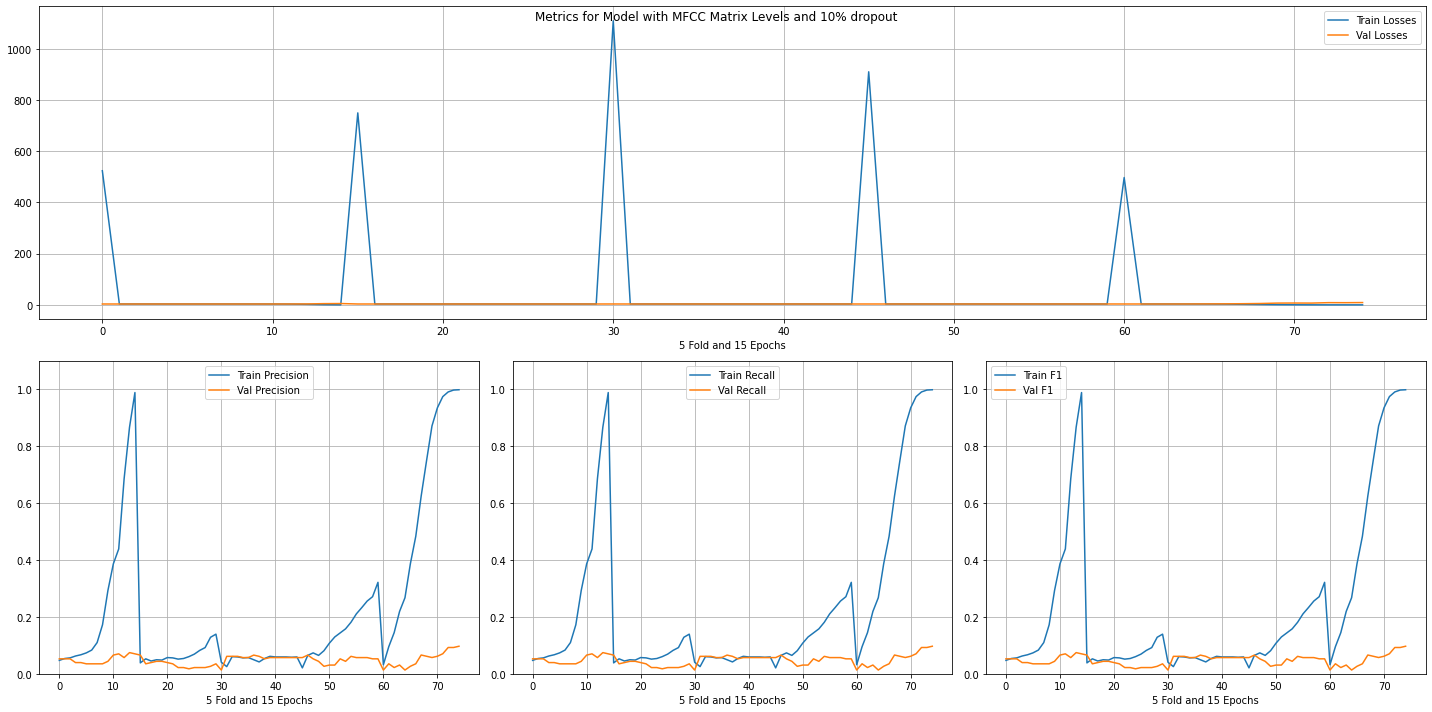

In [47]:
mfcc_matrix_results = train_model(data, MfccMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : 'Model with MFCC Matrix Levels and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MfccRaga})

In [48]:
print('*** Results for Model with MFCC Matrix Levels and 10% dropout ***')
mfcc_matrix_results_df = results_to_df(mfcc_matrix_results)
mfcc_matrix_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with MFCC Matrix Levels and 10% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
14,0.998904,0.096916,0.998904,0.096916,0.998904,0.096916,0.006633,9.022481
13,0.997807,0.092511,0.997807,0.092511,0.997807,0.092511,0.018250,8.519304
12,0.991228,0.092511,0.991228,0.092511,0.991228,0.092511,0.051744,8.666571
13,0.867179,0.074561,0.867179,0.074561,0.867179,0.074561,0.733881,4.795120
11,0.974781,0.070485,0.974781,0.070485,0.974781,0.070485,0.156682,6.940712
...,...,...,...,...,...,...,...,...
7,0.051592,0.021930,0.051592,0.021930,0.051592,0.021930,3.395563,3.400582
9,0.060373,0.017544,0.060373,0.017544,0.060373,0.017544,3.392835,3.400765
4,0.267544,0.013216,0.267544,0.013216,0.267544,0.013216,3.248568,3.566995
0,0.031798,0.013216,0.031798,0.013216,0.031798,0.013216,497.380904,3.412945


FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 508.706 / Validation : 3.401
Time for epoch : 3.362831 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.401 / Validation : 3.402
Time for epoch : 3.268633 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.400 / Validation : 3.402
Time for epoch : 3.270886 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.399 / Validation : 3.402
Time for epoch : 3.278637 seconds
Epoch 5

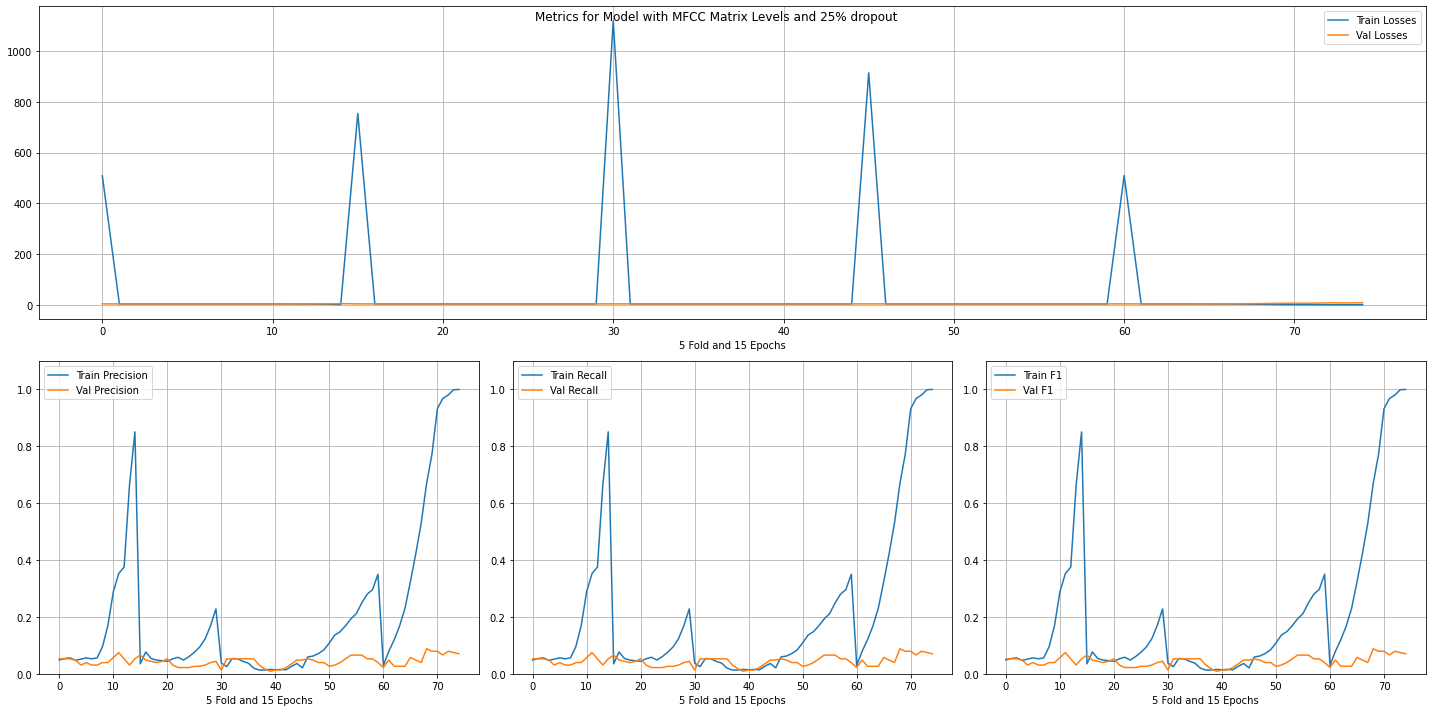

In [50]:
mfcc_matrix_results = train_model(data, MfccMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.25,
                                   'title' : 'Model with MFCC Matrix Levels and 25% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MfccRaga})

In [51]:
print('*** Results for Model with MFCC Matrix Levels and 25% dropout ***')
mfcc_matrix_results_df = results_to_df(mfcc_matrix_results)
mfcc_matrix_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with MFCC Matrix Levels and 25% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
8,0.668860,0.088106,0.668860,0.088106,0.668860,0.088106,1.834490,4.573021
12,0.980263,0.079295,0.980263,0.079295,0.980263,0.079295,0.074603,7.483394
10,0.932018,0.079295,0.932018,0.079295,0.932018,0.079295,0.556210,6.105665
9,0.773026,0.079295,0.773026,0.079295,0.773026,0.079295,1.078862,5.486325
13,0.998904,0.074890,0.998904,0.074890,0.998904,0.074890,0.011564,7.091779
...,...,...,...,...,...,...,...,...
8,0.013172,0.017544,0.013172,0.017544,0.013172,0.017544,3.401577,3.402138
0,0.037322,0.013158,0.037322,0.013158,0.037322,0.013158,1120.234330,3.439645
11,0.015368,0.013158,0.015368,0.013158,0.015368,0.013158,3.401360,3.401790
10,0.014270,0.013158,0.014270,0.013158,0.014270,0.013158,3.401488,3.401900


FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 480.488 / Validation : 3.401
Time for epoch : 3.386609 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.400 / Validation : 3.401
Time for epoch : 3.318549 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.400 / Validation : 3.402
Time for epoch : 3.30179 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.398 / Validation : 3.402
Time for epoch : 3.273686 seconds
Epoch 5 

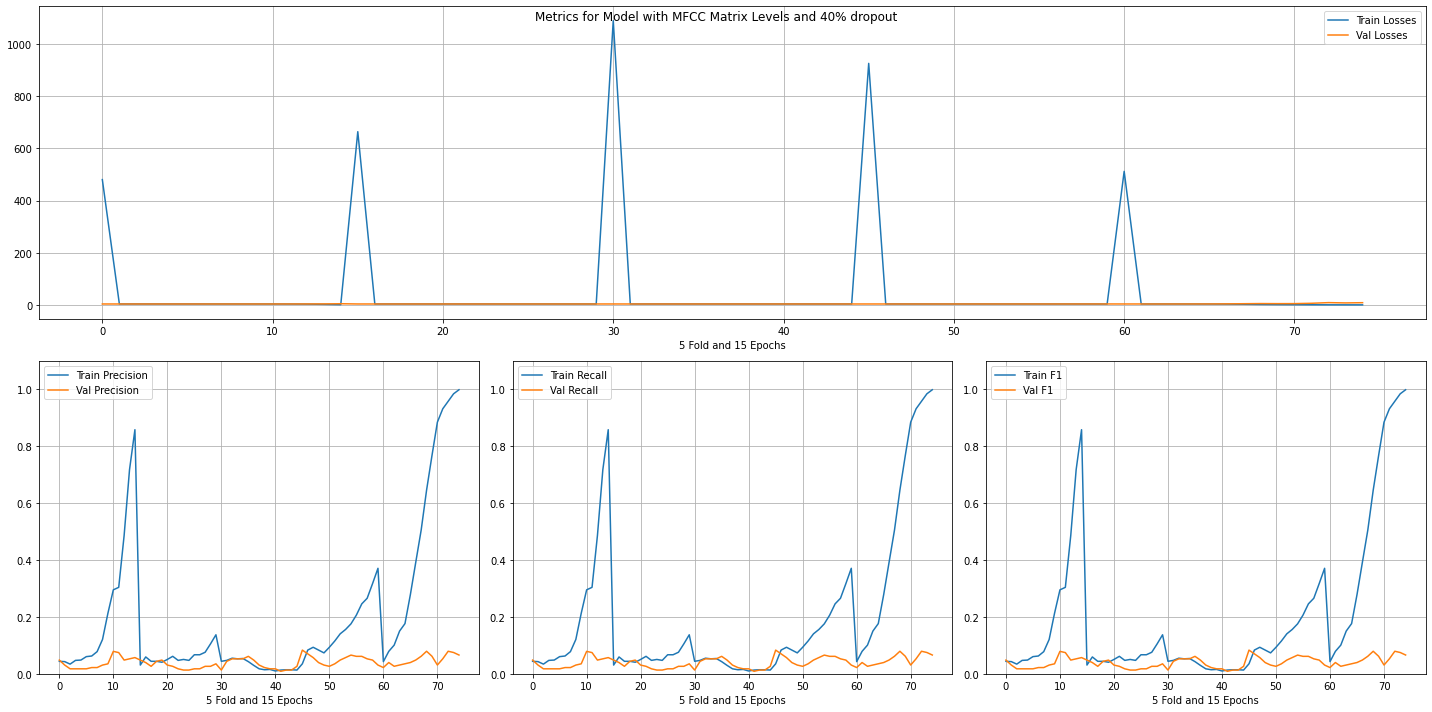

In [52]:
mfcc_matrix_results = train_model(data, MfccMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.4,
                                   'title' : 'Model with MFCC Matrix Levels and 40% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MfccRaga})

In [53]:
print('*** Results for Model with MFCC Matrix Levels and 40% dropout ***')
mfcc_matrix_results_df = results_to_df(mfcc_matrix_results)
mfcc_matrix_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with MFCC Matrix Levels and 40% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
0,0.035126,0.083333,0.035126,0.083333,0.035126,0.083333,926.409216,3.400962
12,0.958333,0.079295,0.958333,0.079295,0.958333,0.079295,0.194107,8.607588
8,0.645833,0.079295,0.645833,0.079295,0.645833,0.079295,1.581854,4.963837
10,0.295280,0.078947,0.295280,0.078947,0.295280,0.078947,3.316275,3.406680
13,0.984649,0.074890,0.984649,0.074890,0.984649,0.074890,0.068684,7.461613
...,...,...,...,...,...,...,...,...
9,0.047201,0.013158,0.047201,0.013158,0.047201,0.013158,3.391703,3.400603
0,0.043908,0.013158,0.043908,0.013158,0.043908,0.013158,1090.218448,3.429418
12,0.014270,0.013158,0.014270,0.013158,0.014270,0.013158,3.401117,3.401938
13,0.014270,0.013158,0.014270,0.013158,0.014270,0.013158,3.401207,3.401810


## Experiment 2.2 MFCC 120 Sec Bidirectional LSTM

In [65]:
class MfccLstmModel(nn.Module):
    def __init__(self, n_labels, dropout=0.25, n_layers=2):
        super().__init__()
        self.input_dim = 40
        self.hidden_dim = self.input_dim
        self.n_layers = n_layers
        self.seq_len = 9601
        self.n_labels = n_labels
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Sequential(nn.Linear(2*self.hidden_dim,160),
                                nn.GELU(),
                                nn.Linear(160,self.n_labels))

    def forward(self,x,h):
        x = x.reshape((x.shape[0],x.shape[2],x.shape[3]))
        out, (hn, cn) = self.rnn(x.permute(0, 2, 1), h)
        x_forward = out[range(len(out)), self.seq_len - 1, :self.hidden_dim]
        x_reverse = out[:, 0, self.hidden_dim:]
        x = torch.cat((x_forward, x_reverse), 1)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size, target_device):
        weight = next(self.parameters()).data
        # Bi directional LSTM
        hidden = (weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device),
                  weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device))
        return hidden

FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.416 / Validation : 3.412
Time for epoch : 47.717747 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.378 / Validation : 3.453
Time for epoch : 47.722738 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.255 / Validation : 3.534
Time for epoch : 47.761994 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.049 / Validation : 3.769
Time for epoch : 47.75004 seconds
Epoch 

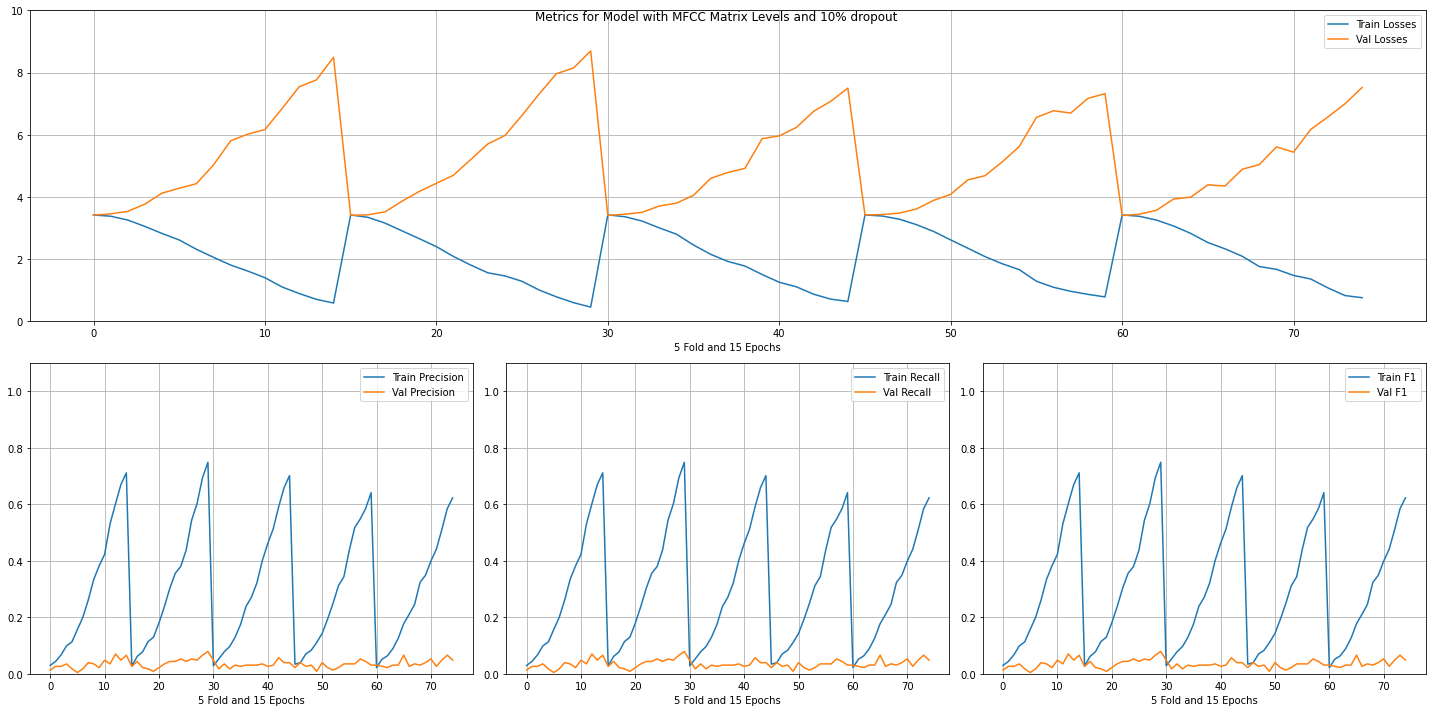

In [66]:
mfcc_matrix_bidir_lstm_results = train_model(data, MfccMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : True,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : 'Model with MFCC Matrix Levels and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MfccLstmModel,
                                   'mdlargs' : {'n_layers' : 2}})

In [67]:
print('*** Results for LSTM Model with MFCC Matrix Levels and 10% dropout ***')
mfcc_matrix_bidir_lstm_results_df = results_to_df(mfcc_matrix_bidir_lstm_results)
mfcc_matrix_bidir_lstm_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for LSTM Model with MFCC Matrix Levels and 10% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
14,0.748628,0.078947,0.748628,0.078947,0.748628,0.078947,0.453465,8.694915
12,0.601537,0.070175,0.601537,0.070175,0.601537,0.070175,0.889976,7.543855
13,0.584430,0.066079,0.584430,0.066079,0.584430,0.066079,0.824469,6.995863
5,0.177632,0.066079,0.177632,0.066079,0.177632,0.066079,2.530216,4.387205
14,0.711306,0.065789,0.711306,0.065789,0.711306,0.065789,0.584084,8.489863
...,...,...,...,...,...,...,...,...
7,0.249177,0.013158,0.249177,0.013158,0.249177,0.013158,2.078016,4.681708
0,0.029638,0.013158,0.029638,0.013158,0.029638,0.013158,3.416414,3.412362
4,0.129528,0.008772,0.129528,0.008772,0.129528,0.008772,2.656353,4.174769
4,0.110867,0.008772,0.110867,0.008772,0.110867,0.008772,2.887590,3.886515


FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.418 / Validation : 3.410
Time for epoch : 47.584852 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.384 / Validation : 3.414
Time for epoch : 47.634924 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.285 / Validation : 3.456
Time for epoch : 47.53014 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.139 / Validation : 3.481
Time for epoch : 47.652576 seconds
Epoch 

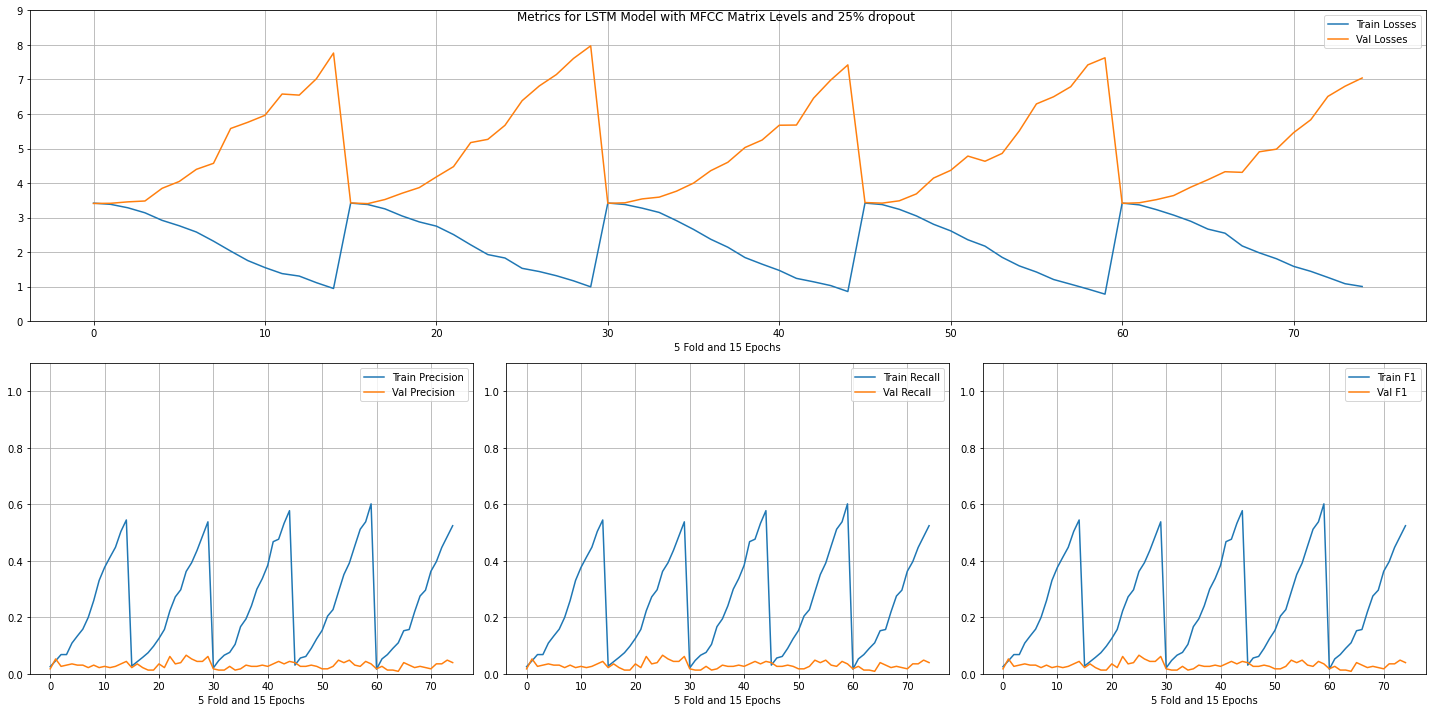

In [68]:
mfcc_matrix_bidir_lstm_results = train_model(data, MfccMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : True,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.25,
                                   'title' : 'LSTM Model with MFCC Matrix Levels and 25% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MfccLstmModel,
                                   'mdlargs' : {'n_layers' : 2}})

In [69]:
print('*** Results for LSTM Model with MFCC Matrix Levels and 25% dropout ***')
mfcc_matrix_bidir_lstm_results_df = results_to_df(mfcc_matrix_bidir_lstm_results)
mfcc_matrix_bidir_lstm_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for LSTM Model with MFCC Matrix Levels and 25% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
10,0.362239,0.065789,0.362239,0.065789,0.362239,0.065789,1.531109,6.384818
14,0.537870,0.061404,0.537870,0.061404,0.537870,0.061404,0.995119,7.973163
7,0.222832,0.061404,0.222832,0.061404,0.222832,0.061404,2.211770,5.172464
11,0.392975,0.052632,0.392975,0.052632,0.392975,0.052632,1.438195,6.811848
1,0.046103,0.052632,0.046103,0.052632,0.046103,0.052632,3.383948,3.414291
...,...,...,...,...,...,...,...,...
4,0.097695,0.013158,0.097695,0.013158,0.097695,0.013158,2.875488,3.868241
3,0.074643,0.013158,0.074643,0.013158,0.074643,0.013158,3.047227,3.705781
2,0.065862,0.013158,0.065862,0.013158,0.065862,0.013158,3.274181,3.541053
1,0.047201,0.013158,0.047201,0.013158,0.047201,0.013158,3.378600,3.428190


FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.419 / Validation : 3.413
Time for epoch : 47.568151 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.385 / Validation : 3.413
Time for epoch : 47.555134 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.268 / Validation : 3.555
Time for epoch : 47.595252 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.113 / Validation : 3.689
Time for epoch : 47.647872 seconds
Epoch

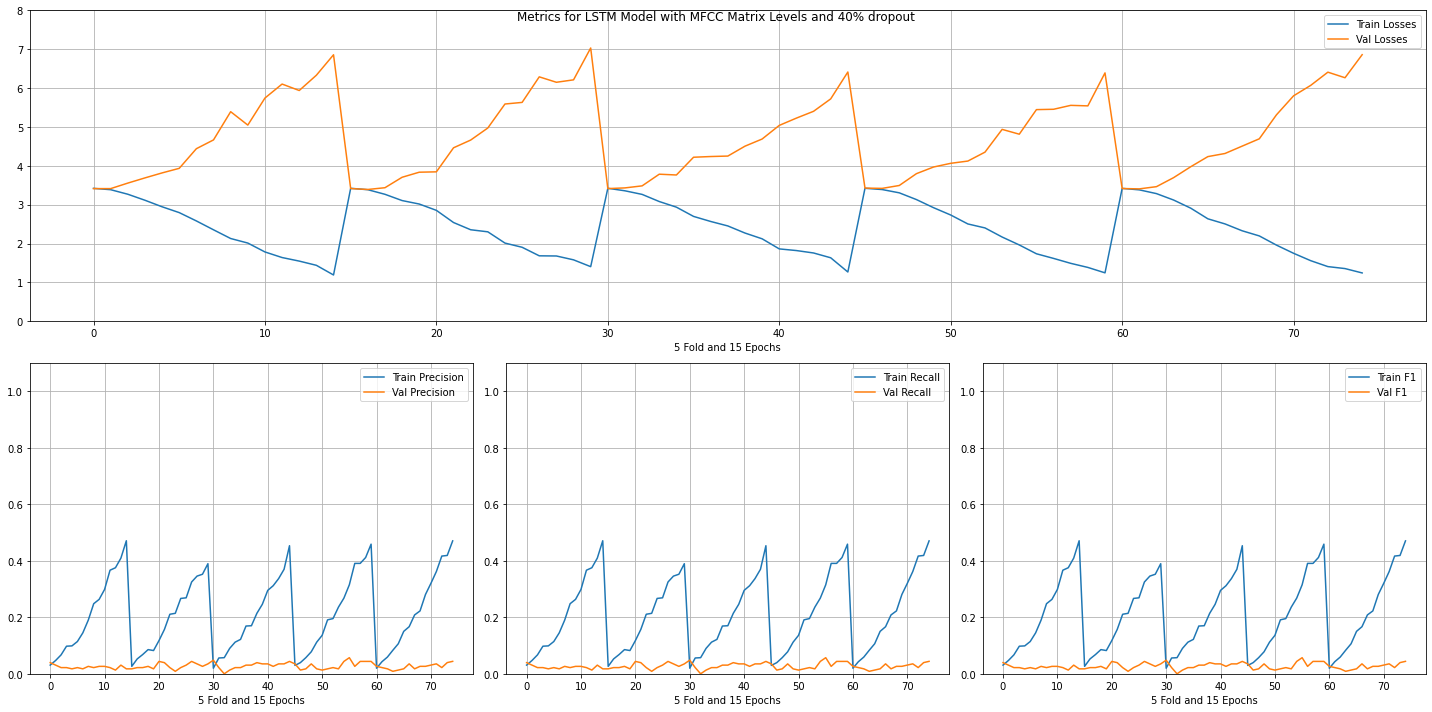

In [70]:
mfcc_matrix_bidir_lstm_results = train_model(data, MfccMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : True,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.4,
                                   'title' : 'LSTM Model with MFCC Matrix Levels and 40% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MfccLstmModel,
                                   'mdlargs' : {'n_layers' : 2}})

In [71]:
print('*** Results for LSTM Model with MFCC Matrix Levels and 40% dropout ***')
mfcc_matrix_bidir_lstm_results_df = results_to_df(mfcc_matrix_bidir_lstm_results)
mfcc_matrix_bidir_lstm_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for LSTM Model with MFCC Matrix Levels and 40% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
10,0.315038,0.057018,0.315038,0.057018,0.315038,0.057018,1.735535,5.446053
0,0.019759,0.048246,0.019759,0.048246,0.019759,0.048246,3.421098,3.413405
14,0.470395,0.044053,0.470395,0.044053,0.470395,0.044053,1.242078,6.860301
14,0.458836,0.043860,0.458836,0.043860,0.458836,0.043860,1.244757,6.391485
14,0.453348,0.043860,0.453348,0.043860,0.453348,0.043860,1.266376,6.413973
...,...,...,...,...,...,...,...,...
3,0.090011,0.013158,0.090011,0.013158,0.090011,0.013158,3.080073,3.783927
1,0.039517,0.013158,0.039517,0.013158,0.039517,0.013158,3.388863,3.418651
3,0.083333,0.008811,0.083333,0.008811,0.083333,0.008811,3.119092,3.694767
8,0.214050,0.008772,0.214050,0.008772,0.214050,0.008772,2.300601,4.973338


# Experiment 3 - Using Mel Spectrogram with 40 Mel Levels  for 120 sec duration of each song
## Experiment 3.1 - Using Feed forward model

In [72]:
FREQ = 16000
DURATION = 120
mel_tx = transforms.MelSpectrogram(FREQ,n_mels=40)
def get_mels(x, aud_path, mel_tx):
  aud_path = os.path.join(aud_path, x['MP3 File'])
  i = torchaudio.info(aud_path)
  waveform, sample_rate = torchaudio.load(aud_path, 
                                          frame_offset=int(x['Offset']*i.sample_rate), 
                                          num_frames= DURATION*i.sample_rate)
  waveform = librosa.to_mono(waveform)
  resampler = transforms.Resample(sample_rate, FREQ)
  if len(waveform) > 0 :
    waveform = resampler(torch.tensor(waveform))
    mel = mel_tx(waveform)
  else:
    mel = []
  return mel
data['mel_spec'] = data.apply(lambda x:get_mels(x, AUD_PATH, mel_tx),axis=1)

In [74]:
class MelMatrixDataset(AbsDataset):
    def __init__(self, labels, mels):
        super().__init__()
        self.labels = labels
        self.mels = mels

    def __get__(self,index):
      if self.mels[index].shape[1] < 9601:
        self.mels[index] = torch.hstack((self.mels[index],torch.zeros(40,9601-self.mels[index].shape[1])))
      return self.mels[index].reshape((1,)+self.mels[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mel_spec'].iloc[x] for x in train_ids]
      test_vals = [data['mel_spec'].iloc[x] for x in test_ids]
      train_data = MelMatrixDataset(train_lbls, train_vals)
      test_data = MelMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [73]:
class MelRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 40
        self.width = 9601
        # Fully connected audio layer with MEL Spectrogram Matrix 40x9601 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.final = nn.Linear(384000,n_labels)
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 1330.601 / Validation : 3.379
Time for epoch : 3.572714 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.374 / Validation : 3.380
Time for epoch : 3.390156 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.363 / Validation : 3.379
Time for epoch : 3.38914 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.338 / Validation : 3.377
Time for epoch : 3.480084 seconds
Epoch 5

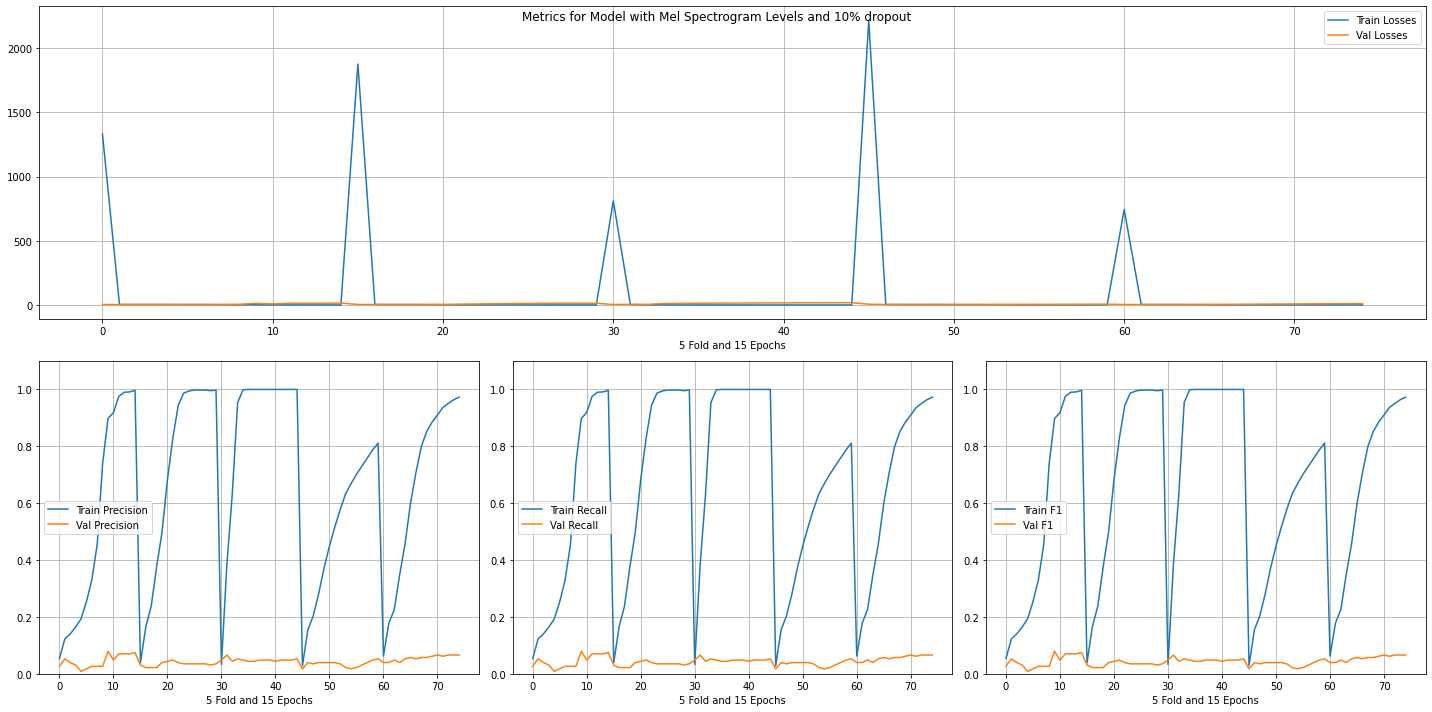

In [75]:
mel_spec_results = train_model(data, MelMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : 'Model with Mel Spectrogram Levels and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MelRaga})

In [76]:
print('*** Results for Model with Mel Spectrogram Levels and 10% dropout ***')
mel_spec_results_df = results_to_df(mel_spec_results)
mel_spec_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with Mel Spectrogram Levels and 10% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
9,0.897914,0.078947,0.897914,0.078947,0.897914,0.078947,1.101014,12.064688
14,0.996707,0.074561,0.996707,0.074561,0.996707,0.074561,0.080031,14.574605
13,0.991218,0.070175,0.991218,0.070175,0.991218,0.070175,0.106272,13.008705
12,0.990121,0.070175,0.990121,0.070175,0.990121,0.070175,0.134931,12.771763
11,0.975851,0.070175,0.975851,0.070175,0.975851,0.070175,0.273289,13.336310
...,...,...,...,...,...,...,...,...
1,0.165752,0.021930,0.165752,0.021930,0.165752,0.021930,3.353418,3.457837
9,0.668496,0.017544,0.668496,0.017544,0.668496,0.017544,1.874327,4.526767
5,0.253568,0.017544,0.253568,0.017544,0.253568,0.017544,3.215502,3.379614
0,0.028540,0.017544,0.028540,0.017544,0.028540,0.017544,2214.740027,5.960953


FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 1357.979 / Validation : 3.395
Time for epoch : 3.473764 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.380 / Validation : 3.388
Time for epoch : 3.49259 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.368 / Validation : 3.388
Time for epoch : 3.380651 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.349 / Validation : 3.386
Time for epoch : 3.495427 seconds
Epoch 5

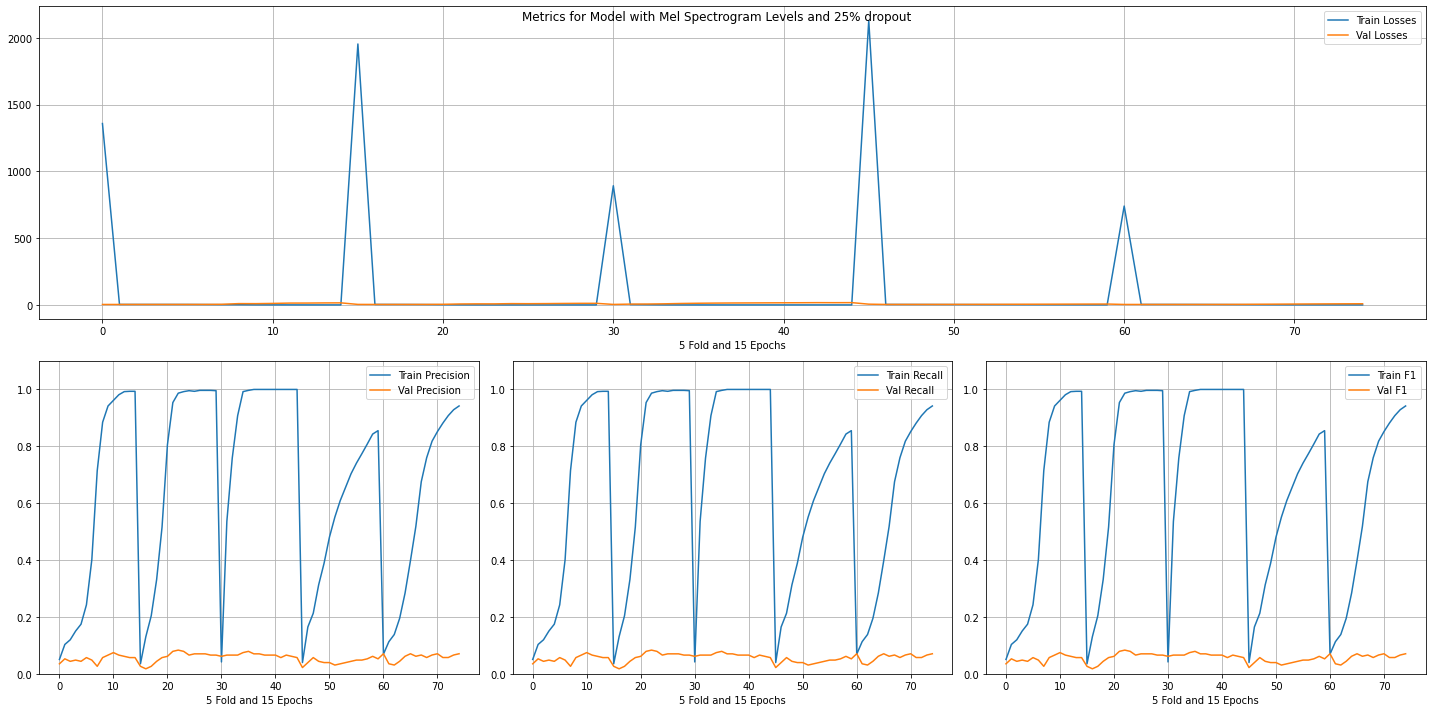

In [78]:
mel_spec_results = train_model(data, MelMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.25,
                                   'title' : 'Model with Mel Spectrogram Levels and 25% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MelRaga})

In [79]:
print('*** Results for Model with Mel Spectrogram Levels and 25% dropout ***')
mel_spec_results_df = results_to_df(mel_spec_results)
mel_spec_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with Mel Spectrogram Levels and 25% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
7,0.986828,0.083333,0.986828,0.083333,0.986828,0.083333,0.269264,7.805211
5,0.996707,0.078947,0.996707,0.078947,0.996707,0.078947,0.057086,12.445561
8,0.992316,0.078947,0.992316,0.078947,0.992316,0.078947,0.156355,7.722595
6,0.953897,0.078947,0.953897,0.078947,0.953897,0.078947,0.653317,6.987077
4,0.992316,0.074561,0.992316,0.074561,0.992316,0.074561,0.125975,10.765194
...,...,...,...,...,...,...,...,...
7,0.714599,0.026316,0.714599,0.026316,0.714599,0.026316,1.892289,4.435983
2,0.204171,0.026316,0.204171,0.026316,0.204171,0.026316,3.209312,3.459064
0,0.035126,0.026316,0.035126,0.026316,0.035126,0.026316,1953.590428,3.773858
0,0.039517,0.021930,0.039517,0.021930,0.039517,0.021930,2128.357893,5.533959


FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 1292.504 / Validation : 3.372
Time for epoch : 3.476576 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.388 / Validation : 3.381
Time for epoch : 3.408308 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.375 / Validation : 3.381
Time for epoch : 3.377435 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.351 / Validation : 3.378
Time for epoch : 3.392295 seconds
Epoch 

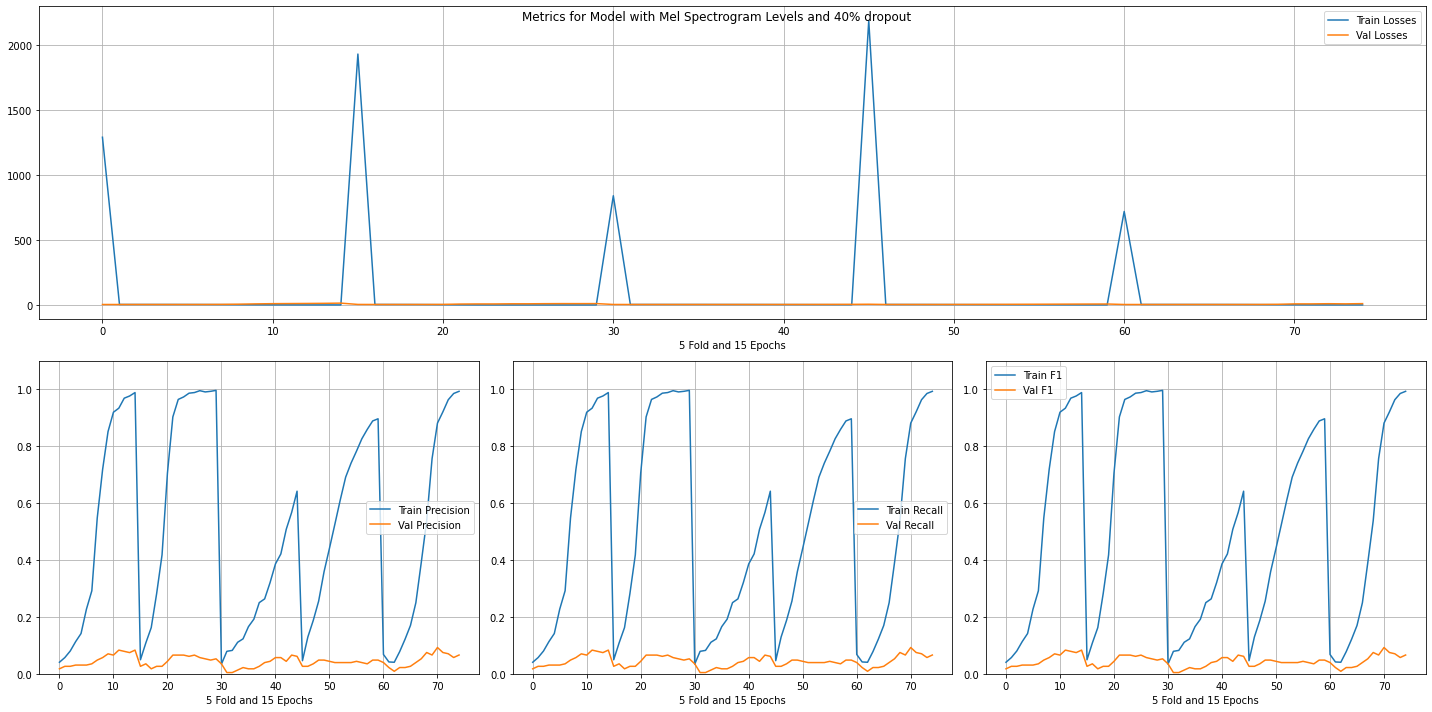

In [80]:
mel_spec_results = train_model(data, MelMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.4,
                                   'title' : 'Model with Mel Spectrogram Levels and 40% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MelRaga})

In [81]:
print('*** Results for Model with Mel Spectrogram Levels and 40% dropout ***')
mel_spec_results_df = results_to_df(mel_spec_results)
mel_spec_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with Mel Spectrogram Levels and 40% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
10,0.881579,0.092511,0.881579,0.092511,0.881579,0.092511,1.035291,7.989116
14,0.989023,0.083333,0.989023,0.083333,0.989023,0.083333,0.181240,13.875114
11,0.934138,0.083333,0.934138,0.083333,0.934138,0.083333,0.404515,10.586523
12,0.969265,0.078947,0.969265,0.078947,0.969265,0.078947,0.290786,11.354827
11,0.921053,0.074890,0.921053,0.074890,0.921053,0.074890,0.552845,8.026417
...,...,...,...,...,...,...,...,...
0,0.040615,0.017544,0.040615,0.017544,0.040615,0.017544,1292.503685,3.372108
3,0.110867,0.013158,0.110867,0.013158,0.110867,0.013158,3.334451,3.411550
2,0.040570,0.008811,0.040570,0.008811,0.040570,0.008811,3.389996,3.392345
2,0.082327,0.004386,0.082327,0.004386,0.082327,0.004386,3.355685,3.410798


## Experiment 3.2 Mel Spectrogram Bi Directional LSTM Analysis

In [82]:
class MelLstmModel(nn.Module):
    def __init__(self, n_labels, dropout=0.25, n_layers=2):
        super().__init__()
        self.input_dim = 40
        self.hidden_dim = self.input_dim
        self.n_layers = n_layers
        self.seq_len = 9601
        self.n_labels = n_labels
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Sequential(nn.Linear(2*self.hidden_dim,160),
                                nn.GELU(),
                                nn.Linear(160,self.n_labels))

    def forward(self,x,h):
        x = x.reshape((x.shape[0],x.shape[2],x.shape[3]))
        out, (hn, cn) = self.rnn(x.permute(0, 2, 1), h)
        x_forward = out[range(len(out)), self.seq_len - 1, :self.hidden_dim]
        x_reverse = out[:, 0, self.hidden_dim:]
        x = torch.cat((x_forward, x_reverse), 1)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size, target_device):
        weight = next(self.parameters()).data
        # Bi directional LSTM
        hidden = (weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device),
                  weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device))
        return hidden

FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.418 / Validation : 3.405
Time for epoch : 47.89277 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.344 / Validation : 3.520
Time for epoch : 47.858302 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.138 / Validation : 3.717
Time for epoch : 47.963793 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 2.885 / Validation : 3.952
Time for epoch : 47.88838 seconds
Epoch 5

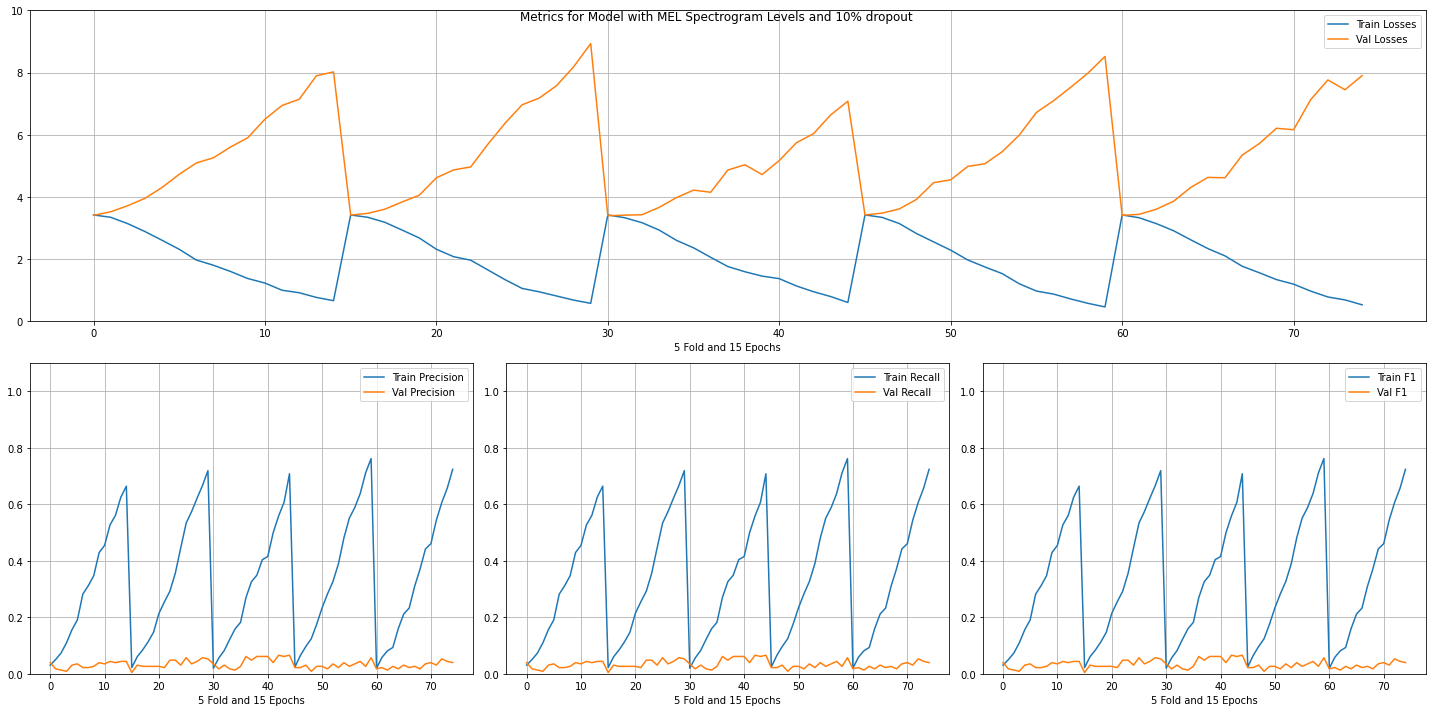

In [83]:
mel_spec_bidir_lstm_results = train_model(data, MelMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : True,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : 'Model with MEL Spectrogram Levels and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MelLstmModel,
                                   'mdlargs' : {'n_layers' : 2}})

In [84]:
print('*** Results for Model with Mel Spectrogram Levels and 10% dropout ***')
mel_spec_bidir_lstm_results_df = results_to_df(mel_spec_bidir_lstm_results)
mel_spec_bidir_lstm_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with Mel Spectrogram Levels and 10% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
14,0.708013,0.065789,0.708013,0.065789,0.708013,0.065789,0.602345,7.078682
12,0.558727,0.065789,0.558727,0.065789,0.558727,0.065789,0.948559,6.034260
13,0.607025,0.061404,0.607025,0.061404,0.607025,0.061404,0.792770,6.637844
10,0.414929,0.061404,0.414929,0.061404,0.414929,0.061404,1.368691,5.170105
9,0.403952,0.061404,0.403952,0.061404,0.403952,0.061404,1.451100,4.717200
...,...,...,...,...,...,...,...,...
4,0.159166,0.013158,0.159166,0.013158,0.159166,0.013158,2.602324,3.976097
2,0.073546,0.013158,0.073546,0.013158,0.073546,0.013158,3.137543,3.716810
3,0.124040,0.008772,0.124040,0.008772,0.124040,0.008772,2.822150,3.916714
3,0.109769,0.008772,0.109769,0.008772,0.109769,0.008772,2.885216,3.952453


FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.417 / Validation : 3.410
Time for epoch : 48.017266 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.333 / Validation : 3.570
Time for epoch : 48.04241 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.138 / Validation : 3.753
Time for epoch : 48.03155 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 2.900 / Validation : 4.217
Time for epoch : 47.869453 seconds
Epoch 5

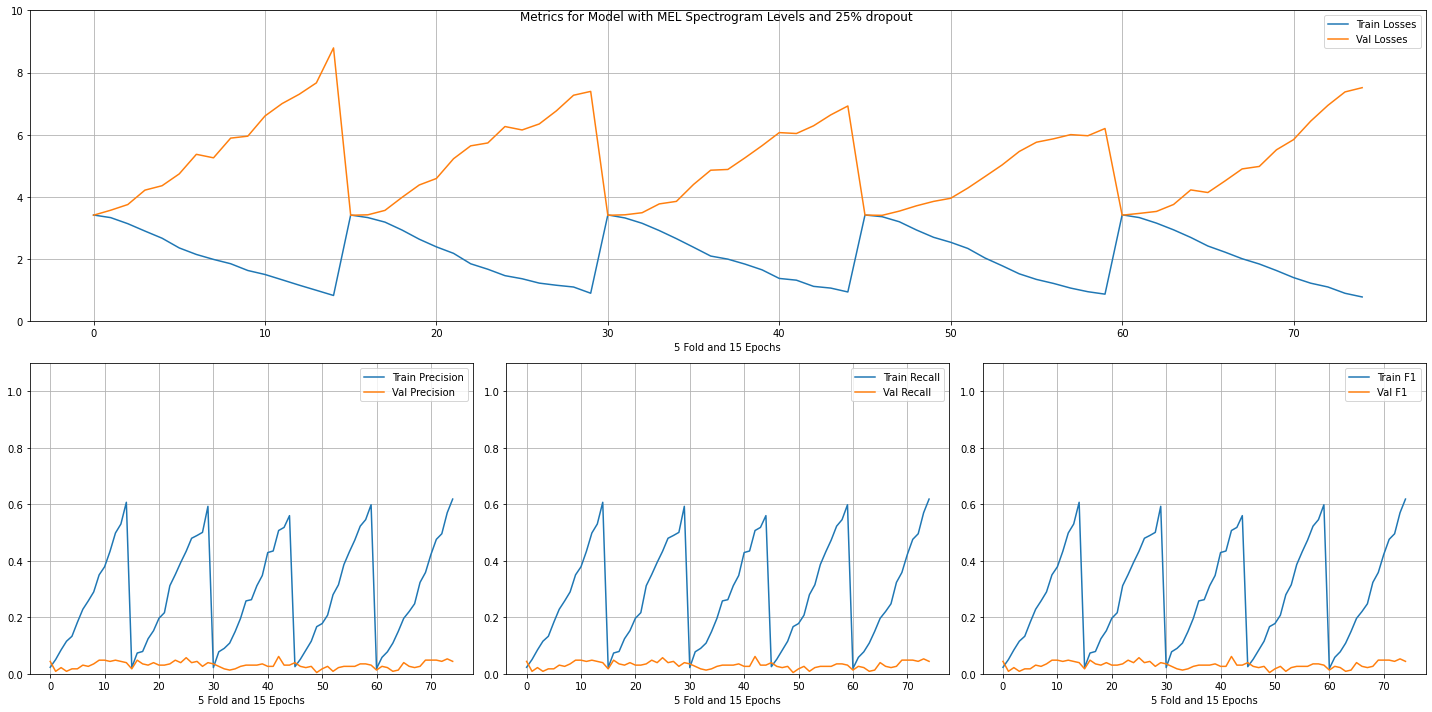

In [85]:
mel_spec_bidir_lstm_results = train_model(data, MelMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : True,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.25,
                                   'title' : 'Model with MEL Spectrogram Levels and 25% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MelLstmModel,
                                   'mdlargs' : {'n_layers' : 2}})

In [86]:
print('*** Results for Model with Mel Spectrogram Levels and 25% dropout ***')
mel_spec_bidir_lstm_results_df = results_to_df(mel_spec_bidir_lstm_results)
mel_spec_bidir_lstm_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with Mel Spectrogram Levels and 25% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
12,0.507135,0.061404,0.507135,0.061404,0.507135,0.061404,1.120702,6.287441
10,0.433589,0.057018,0.433589,0.057018,0.433589,0.057018,1.365701,6.153113
13,0.570175,0.052863,0.570175,0.052863,0.570175,0.052863,0.898313,7.377059
11,0.475877,0.048458,0.475877,0.048458,0.475877,0.048458,1.222746,6.438070
10,0.422149,0.048458,0.422149,0.048458,0.422149,0.048458,1.402701,5.842747
...,...,...,...,...,...,...,...,...
3,0.108553,0.008811,0.108553,0.008811,0.108553,0.008811,2.939521,3.755724
7,0.279912,0.008772,0.279912,0.008772,0.279912,0.008772,2.033437,4.653716
3,0.115258,0.008772,0.115258,0.008772,0.115258,0.008772,2.900089,4.217144
1,0.050494,0.008772,0.050494,0.008772,0.050494,0.008772,3.332684,3.570087


FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.418 / Validation : 3.411
Time for epoch : 47.803131 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.322 / Validation : 3.522
Time for epoch : 47.865817 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.129 / Validation : 3.699
Time for epoch : 47.92316 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 2.943 / Validation : 3.962
Time for epoch : 47.898674 seconds
Epoch 

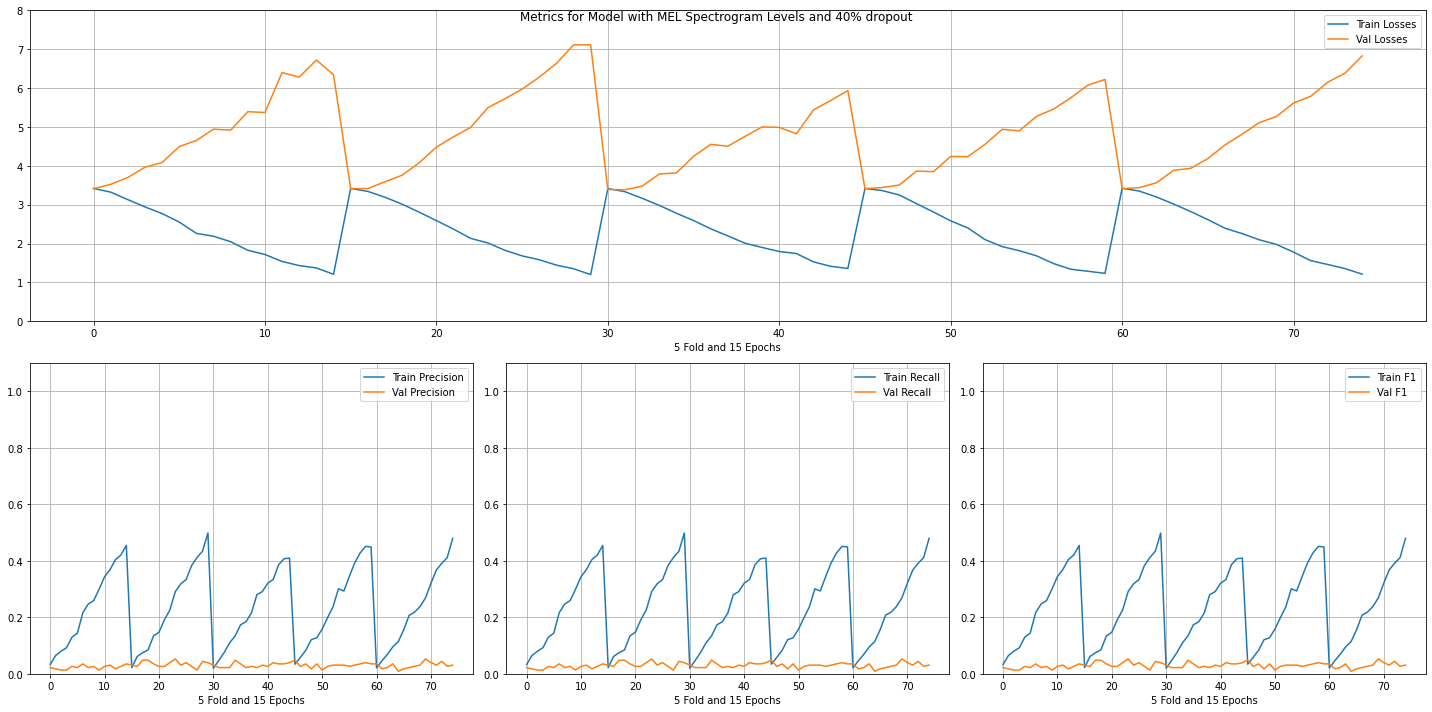

In [87]:
mel_spec_bidir_lstm_results = train_model(data, MelMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : True,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.4,
                                   'title' : 'Model with MEL Spectrogram Levels and 40% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MelLstmModel,
                                   'mdlargs' : {'n_layers' : 2}})

In [88]:
print('*** Results for Model with Mel Spectrogram Levels and 40% dropout ***')
mel_spec_bidir_lstm_results_df = results_to_df(mel_spec_bidir_lstm_results)
mel_spec_bidir_lstm_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with Mel Spectrogram Levels and 40% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
9,0.268640,0.052863,0.268640,0.052863,0.268640,0.052863,1.976657,5.269347
8,0.290889,0.052632,0.290889,0.052632,0.290889,0.052632,2.014674,5.494201
4,0.133919,0.048246,0.133919,0.048246,0.133919,0.048246,2.778241,3.816966
3,0.084523,0.048246,0.084523,0.048246,0.084523,0.048246,3.012543,3.757280
2,0.074643,0.048246,0.074643,0.048246,0.074643,0.048246,3.190613,3.589986
...,...,...,...,...,...,...,...,...
9,0.299671,0.013158,0.299671,0.013158,0.299671,0.013158,1.825302,5.392480
5,0.158068,0.013158,0.158068,0.013158,0.158068,0.013158,2.582429,4.241950
3,0.092206,0.013158,0.092206,0.013158,0.092206,0.013158,2.942508,3.962267
2,0.080132,0.013158,0.080132,0.013158,0.080132,0.013158,3.129400,3.699457
